In [1]:
import os
import random
from tqdm import tqdm

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import plotly.express as px
import torchvision
import torch
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms, datasets

data_dir = 'data'

train_dataset = torchvision.datasets.MNIST(data_dir, train=True, download=True)
test_dataset = torchvision.datasets.MNIST(data_dir, train=False, download=True)

print(train_dataset)
type(train_dataset)

100%|██████████| 9.91M/9.91M [00:00<00:00, 42.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.33MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 10.8MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.46MB/s]

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train


torchvision.datasets.mnist.MNIST

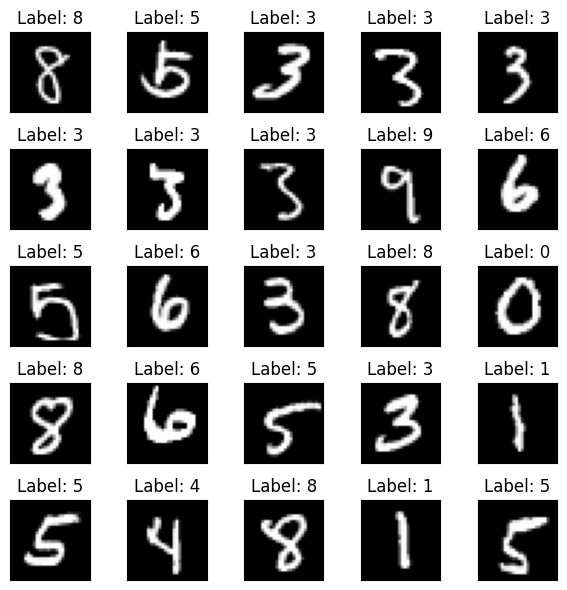

In [2]:
fig, axs = plt.subplots(5, 5, figsize=(6, 6))
for ax in axs.flatten():
    img, label = random.choice(train_dataset)
    ax.imshow(np.array(img), cmap='gist_gray')
    ax.set_title('Label: %d' % label)
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()

In [5]:
import torch
from torchvision import datasets, transforms

class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        noise = torch.rand(tensor.size()) * self.std + self.mean
        return tensor + noise

# Трансформації з шумом
transform_with_noise = transforms.Compose([
    transforms.ToTensor(),
    AddGaussianNoise(mean=0.2, std=0.1),
    transforms.Normalize((0.5,), (0.5,))
])

# Завантаження датасетів з шумом
train_dataset = datasets.MNIST(root='path_to_data', train=True, download=True, transform=transform_with_noise)
test_dataset = datasets.MNIST(root='path_to_data', train=False, download=True, transform=transform_with_noise)

100%|██████████| 9.91M/9.91M [00:00<00:00, 33.4MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.21MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 10.6MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 3.81MB/s]


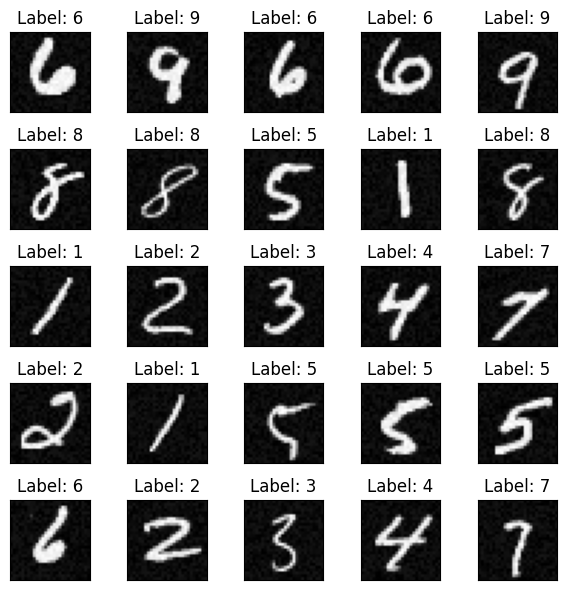

In [6]:
fig, axs = plt.subplots(5, 5, figsize=(6, 6))
for ax in axs.flatten():
    img, label = random.choice(train_dataset)

    # Перетворення тензора з [-1, 1] до [0, 1]
    img = img * 0.5 + 0.5

    ax.imshow(np.array(img).squeeze(), cmap='gist_gray')
    ax.set_title(f'Label: {label}')
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()

In [7]:
m = len(train_dataset)
train_data, val_data = random_split(train_dataset, [int(m * 0.8), int(m * 0.2)])

batch_size = 256

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [14]:
class Encoder(nn.Module):
    def __init__(self, encoded_space_dim):
        super().__init__()
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            nn.ReLU(True)
        )
        self.flatten = nn.Flatten(start_dim=1)
        self.encoder_lin = nn.Sequential(
            nn.Linear(3 * 3 * 32, 128),
            nn.ReLU(True),
            nn.Linear(128, encoded_space_dim)
        )

    def forward(self, x):
        x = self.encoder_cnn(x)
        x = self.flatten(x)
        x = self.encoder_lin(x)
        return x

In [15]:
class Decoder(nn.Module):
    def __init__(self, encoded_space_dim, fc2_input_dim=128):
        super().__init__()
        self.decoder_lin = nn.Sequential(
            nn.Linear(encoded_space_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 7 * 7 * 16),
            nn.ReLU(True)
        )
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(16, 7, 7))
        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(16, 8, 4, stride=2, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 4, stride=2, padding=1)
        )

    def forward(self, x):
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x

In [16]:
torch.manual_seed(42)
encoded_space_dim = 4
encoder = Encoder(encoded_space_dim=encoded_space_dim)
decoder = Decoder(encoded_space_dim=encoded_space_dim)

loss_fn = nn.MSELoss()
lr = 0.001
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]
optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-5)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Selected device: {device}')
encoder.to(device)
decoder.to(device)

Selected device: cpu


Decoder(
  (decoder_lin): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=784, bias=True)
    (3): ReLU(inplace=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(16, 7, 7))
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(16, 8, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(8, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  )
)

In [18]:
def train_epoch(encoder, decoder, device, dataloader, loss_fn, optimizer):
    encoder.train()
    decoder.train()
    train_loss = []

    for image_batch, _ in dataloader:
        image_batch = image_batch.to(device)
        encoded_data = encoder(image_batch)
        decoded_data = decoder(encoded_data)
        loss = loss_fn(decoded_data, image_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        print('\t partial train loss (single batch): %f' % loss.data)
        train_loss.append(loss.detach().cpu().numpy())

    return np.mean(train_loss)

In [19]:
def test_epoch(encoder, decoder, device, dataloader, loss_fn):
    encoder.eval()
    decoder.eval()
    with torch.no_grad():
        conc_out = []
        conc_label = []

        for image_batch, _ in dataloader:
            image_batch = image_batch.to(device)
            encoded_data = encoder(image_batch)
            decoded_data = decoder(encoded_data)

            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())

        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label)
        val_loss = loss_fn(conc_out, conc_label)

    return val_loss.data

In [20]:
def plot_ae_outputs(encoder, decoder, n=5):
    plt.figure(figsize=(10, 4.5))
    for i in range(n):
        ax = plt.subplot(2, n, i + 1)
        img = test_dataset[i][0].unsqueeze(0).to(device)

        encoder.eval()
        decoder.eval()

        with torch.no_grad():
            rec_img = decoder(encoder(img))

        ax.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == n // 2:
            ax.set_title('Original images')

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == n // 2:
            ax.set_title('Reconstructed images')
    plt.show()

	 partial train loss (single batch): 1.105587
	 partial train loss (single batch): 1.083149
	 partial train loss (single batch): 1.065863
	 partial train loss (single batch): 1.053662
	 partial train loss (single batch): 1.041329
	 partial train loss (single batch): 1.029838
	 partial train loss (single batch): 1.022765
	 partial train loss (single batch): 1.012754
	 partial train loss (single batch): 1.005713
	 partial train loss (single batch): 0.993523
	 partial train loss (single batch): 0.990761
	 partial train loss (single batch): 0.982589
	 partial train loss (single batch): 0.973322
	 partial train loss (single batch): 0.967507
	 partial train loss (single batch): 0.960928
	 partial train loss (single batch): 0.953294
	 partial train loss (single batch): 0.947190
	 partial train loss (single batch): 0.943623
	 partial train loss (single batch): 0.937887
	 partial train loss (single batch): 0.933968
	 partial train loss (single batch): 0.925111
	 partial train loss (single batch

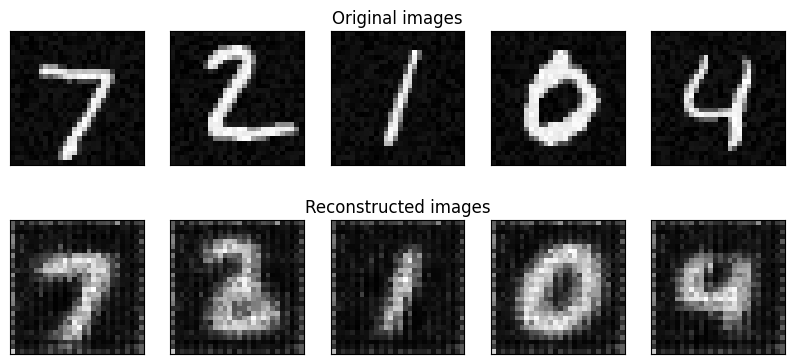

	 partial train loss (single batch): 0.435838
	 partial train loss (single batch): 0.435313
	 partial train loss (single batch): 0.436210
	 partial train loss (single batch): 0.437811
	 partial train loss (single batch): 0.433015
	 partial train loss (single batch): 0.435065
	 partial train loss (single batch): 0.432047
	 partial train loss (single batch): 0.432178
	 partial train loss (single batch): 0.427627
	 partial train loss (single batch): 0.431412
	 partial train loss (single batch): 0.429168
	 partial train loss (single batch): 0.428621
	 partial train loss (single batch): 0.429968
	 partial train loss (single batch): 0.427736
	 partial train loss (single batch): 0.424491
	 partial train loss (single batch): 0.426393
	 partial train loss (single batch): 0.426119
	 partial train loss (single batch): 0.426516
	 partial train loss (single batch): 0.424310
	 partial train loss (single batch): 0.421883
	 partial train loss (single batch): 0.425558
	 partial train loss (single batch

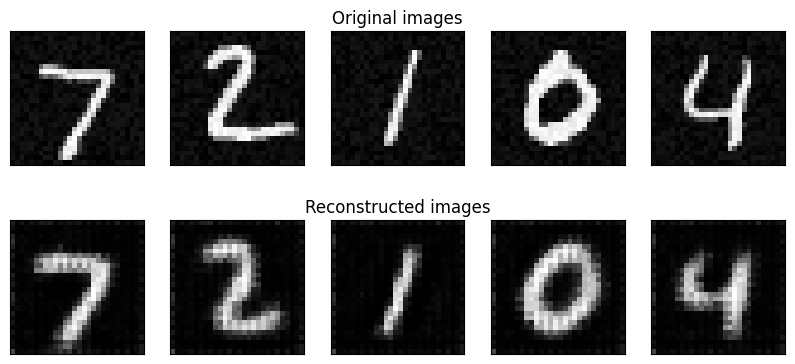

	 partial train loss (single batch): 0.354154
	 partial train loss (single batch): 0.354822
	 partial train loss (single batch): 0.356915
	 partial train loss (single batch): 0.358448
	 partial train loss (single batch): 0.353732
	 partial train loss (single batch): 0.356656
	 partial train loss (single batch): 0.354318
	 partial train loss (single batch): 0.357921
	 partial train loss (single batch): 0.352085
	 partial train loss (single batch): 0.357209
	 partial train loss (single batch): 0.353247
	 partial train loss (single batch): 0.353965
	 partial train loss (single batch): 0.357441
	 partial train loss (single batch): 0.355625
	 partial train loss (single batch): 0.352644
	 partial train loss (single batch): 0.354491
	 partial train loss (single batch): 0.355408
	 partial train loss (single batch): 0.356862
	 partial train loss (single batch): 0.353237
	 partial train loss (single batch): 0.351505
	 partial train loss (single batch): 0.355864
	 partial train loss (single batch

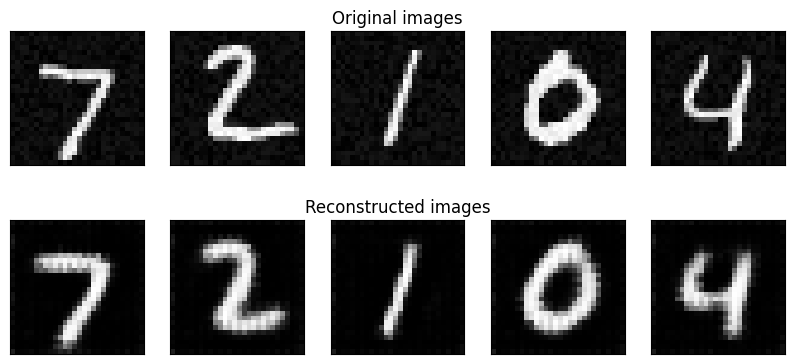

	 partial train loss (single batch): 0.328138
	 partial train loss (single batch): 0.327978
	 partial train loss (single batch): 0.331635
	 partial train loss (single batch): 0.331917
	 partial train loss (single batch): 0.329201
	 partial train loss (single batch): 0.330183
	 partial train loss (single batch): 0.328776
	 partial train loss (single batch): 0.334359
	 partial train loss (single batch): 0.328148
	 partial train loss (single batch): 0.332565
	 partial train loss (single batch): 0.328630
	 partial train loss (single batch): 0.329931
	 partial train loss (single batch): 0.333425
	 partial train loss (single batch): 0.331854
	 partial train loss (single batch): 0.328216
	 partial train loss (single batch): 0.330869
	 partial train loss (single batch): 0.331453
	 partial train loss (single batch): 0.332314
	 partial train loss (single batch): 0.329319
	 partial train loss (single batch): 0.327602
	 partial train loss (single batch): 0.331686
	 partial train loss (single batch

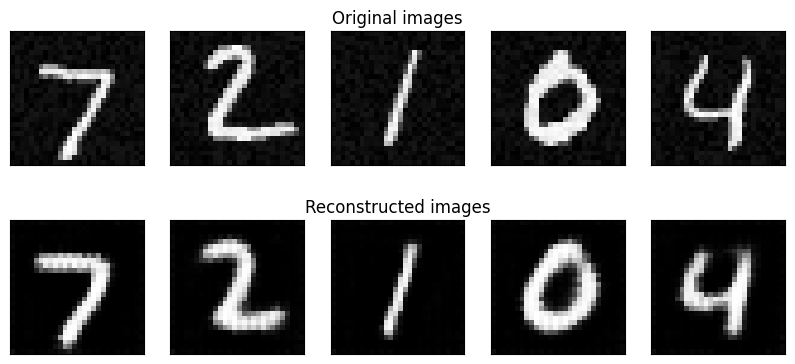

	 partial train loss (single batch): 0.317309
	 partial train loss (single batch): 0.316783
	 partial train loss (single batch): 0.320446
	 partial train loss (single batch): 0.319509
	 partial train loss (single batch): 0.318080
	 partial train loss (single batch): 0.318580
	 partial train loss (single batch): 0.317213
	 partial train loss (single batch): 0.324001
	 partial train loss (single batch): 0.317209
	 partial train loss (single batch): 0.321719
	 partial train loss (single batch): 0.317432
	 partial train loss (single batch): 0.318333
	 partial train loss (single batch): 0.323681
	 partial train loss (single batch): 0.319803
	 partial train loss (single batch): 0.317613
	 partial train loss (single batch): 0.320589
	 partial train loss (single batch): 0.321477
	 partial train loss (single batch): 0.322147
	 partial train loss (single batch): 0.319100
	 partial train loss (single batch): 0.317287
	 partial train loss (single batch): 0.320223
	 partial train loss (single batch

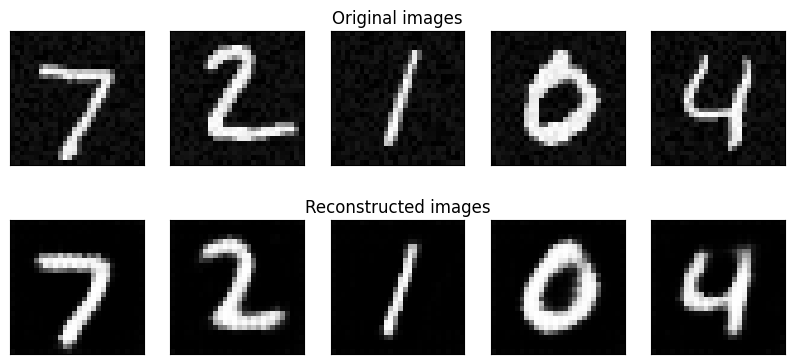

	 partial train loss (single batch): 0.311204
	 partial train loss (single batch): 0.310630
	 partial train loss (single batch): 0.314980
	 partial train loss (single batch): 0.313598
	 partial train loss (single batch): 0.312019
	 partial train loss (single batch): 0.312817
	 partial train loss (single batch): 0.310593
	 partial train loss (single batch): 0.318306
	 partial train loss (single batch): 0.311523
	 partial train loss (single batch): 0.315786
	 partial train loss (single batch): 0.311508
	 partial train loss (single batch): 0.312203
	 partial train loss (single batch): 0.318633
	 partial train loss (single batch): 0.313717
	 partial train loss (single batch): 0.311931
	 partial train loss (single batch): 0.314686
	 partial train loss (single batch): 0.316181
	 partial train loss (single batch): 0.316204
	 partial train loss (single batch): 0.313858
	 partial train loss (single batch): 0.311379
	 partial train loss (single batch): 0.314688
	 partial train loss (single batch

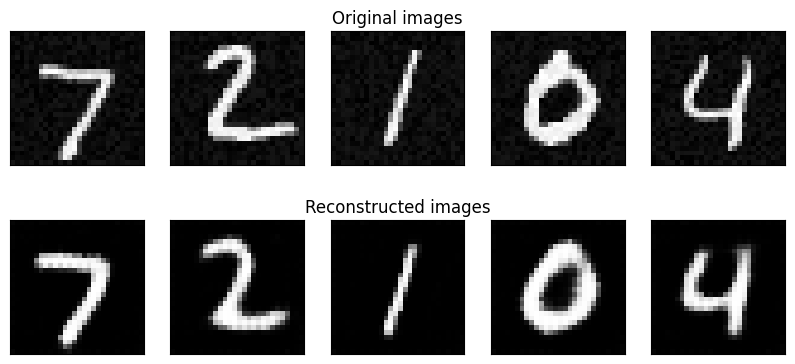

	 partial train loss (single batch): 0.307601
	 partial train loss (single batch): 0.306969
	 partial train loss (single batch): 0.311036
	 partial train loss (single batch): 0.309924
	 partial train loss (single batch): 0.308873
	 partial train loss (single batch): 0.308976
	 partial train loss (single batch): 0.306573
	 partial train loss (single batch): 0.314849
	 partial train loss (single batch): 0.308157
	 partial train loss (single batch): 0.312634
	 partial train loss (single batch): 0.308107
	 partial train loss (single batch): 0.308769
	 partial train loss (single batch): 0.314712
	 partial train loss (single batch): 0.310465
	 partial train loss (single batch): 0.308819
	 partial train loss (single batch): 0.311421
	 partial train loss (single batch): 0.312647
	 partial train loss (single batch): 0.312453
	 partial train loss (single batch): 0.310453
	 partial train loss (single batch): 0.307885
	 partial train loss (single batch): 0.311158
	 partial train loss (single batch

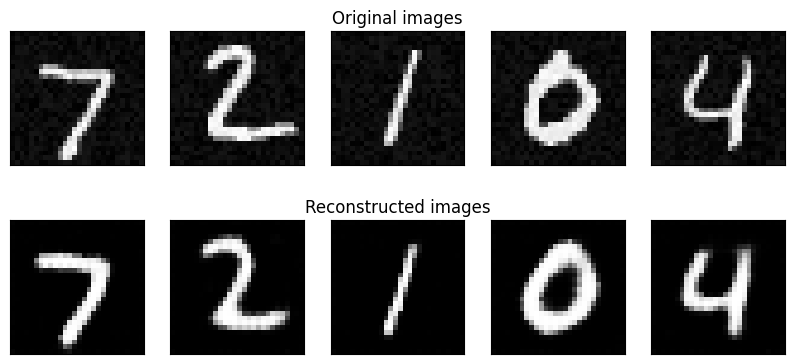

	 partial train loss (single batch): 0.304685
	 partial train loss (single batch): 0.304668
	 partial train loss (single batch): 0.308542
	 partial train loss (single batch): 0.307649
	 partial train loss (single batch): 0.306578
	 partial train loss (single batch): 0.307320
	 partial train loss (single batch): 0.304519
	 partial train loss (single batch): 0.312590
	 partial train loss (single batch): 0.305726
	 partial train loss (single batch): 0.310544
	 partial train loss (single batch): 0.305996
	 partial train loss (single batch): 0.306521
	 partial train loss (single batch): 0.312778
	 partial train loss (single batch): 0.308010
	 partial train loss (single batch): 0.306630
	 partial train loss (single batch): 0.308873
	 partial train loss (single batch): 0.310225
	 partial train loss (single batch): 0.310396
	 partial train loss (single batch): 0.308342
	 partial train loss (single batch): 0.305102
	 partial train loss (single batch): 0.309627
	 partial train loss (single batch

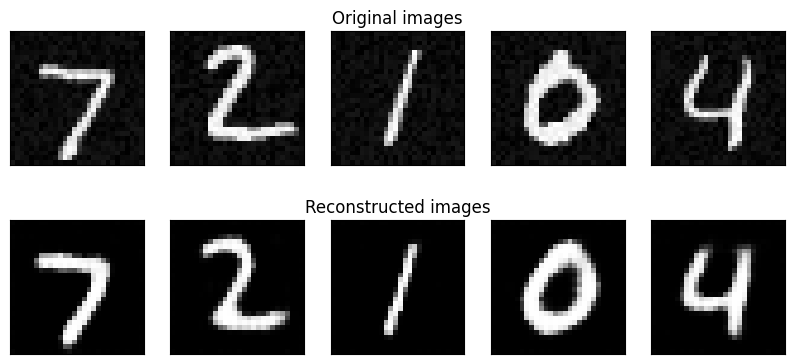

	 partial train loss (single batch): 0.302965
	 partial train loss (single batch): 0.302518
	 partial train loss (single batch): 0.306918
	 partial train loss (single batch): 0.305744
	 partial train loss (single batch): 0.305066
	 partial train loss (single batch): 0.305277
	 partial train loss (single batch): 0.302812
	 partial train loss (single batch): 0.310700
	 partial train loss (single batch): 0.303921
	 partial train loss (single batch): 0.309132
	 partial train loss (single batch): 0.304559
	 partial train loss (single batch): 0.304881
	 partial train loss (single batch): 0.310979
	 partial train loss (single batch): 0.306252
	 partial train loss (single batch): 0.305062
	 partial train loss (single batch): 0.307931
	 partial train loss (single batch): 0.308959
	 partial train loss (single batch): 0.309068
	 partial train loss (single batch): 0.305767
	 partial train loss (single batch): 0.303667
	 partial train loss (single batch): 0.308005
	 partial train loss (single batch

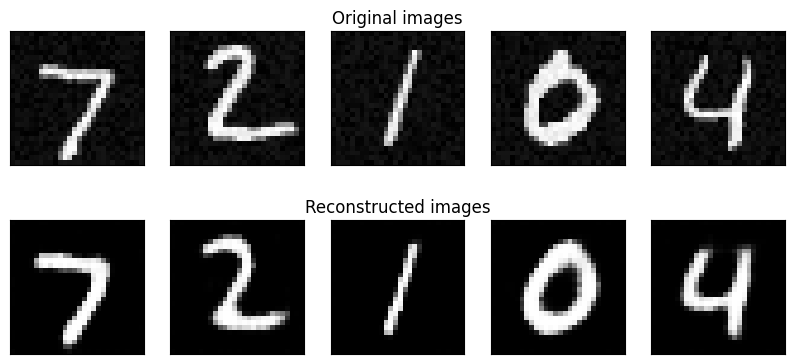

	 partial train loss (single batch): 0.301511
	 partial train loss (single batch): 0.301732
	 partial train loss (single batch): 0.305213
	 partial train loss (single batch): 0.304598
	 partial train loss (single batch): 0.303764
	 partial train loss (single batch): 0.304103
	 partial train loss (single batch): 0.301690
	 partial train loss (single batch): 0.309331
	 partial train loss (single batch): 0.302197
	 partial train loss (single batch): 0.307890
	 partial train loss (single batch): 0.303001
	 partial train loss (single batch): 0.303373
	 partial train loss (single batch): 0.310040
	 partial train loss (single batch): 0.305439
	 partial train loss (single batch): 0.304073
	 partial train loss (single batch): 0.306700
	 partial train loss (single batch): 0.307556
	 partial train loss (single batch): 0.307332
	 partial train loss (single batch): 0.304770
	 partial train loss (single batch): 0.302391
	 partial train loss (single batch): 0.306674
	 partial train loss (single batch

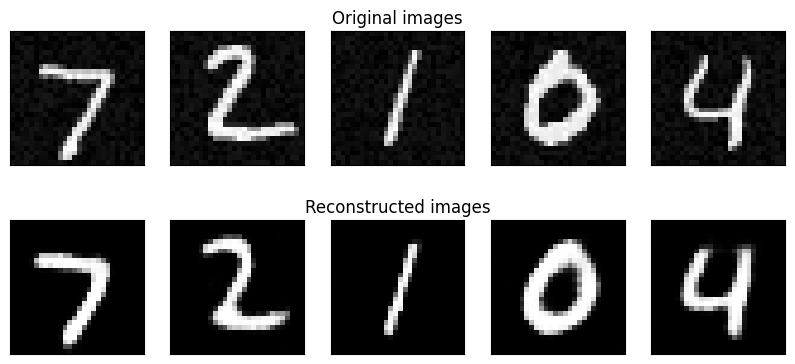

	 partial train loss (single batch): 0.300566
	 partial train loss (single batch): 0.300865
	 partial train loss (single batch): 0.304533
	 partial train loss (single batch): 0.303594
	 partial train loss (single batch): 0.302741
	 partial train loss (single batch): 0.303335
	 partial train loss (single batch): 0.300205
	 partial train loss (single batch): 0.308463
	 partial train loss (single batch): 0.301329
	 partial train loss (single batch): 0.306989
	 partial train loss (single batch): 0.302671
	 partial train loss (single batch): 0.302314
	 partial train loss (single batch): 0.308869
	 partial train loss (single batch): 0.304572
	 partial train loss (single batch): 0.303293
	 partial train loss (single batch): 0.305553
	 partial train loss (single batch): 0.306547
	 partial train loss (single batch): 0.306979
	 partial train loss (single batch): 0.303920
	 partial train loss (single batch): 0.300829
	 partial train loss (single batch): 0.305885
	 partial train loss (single batch

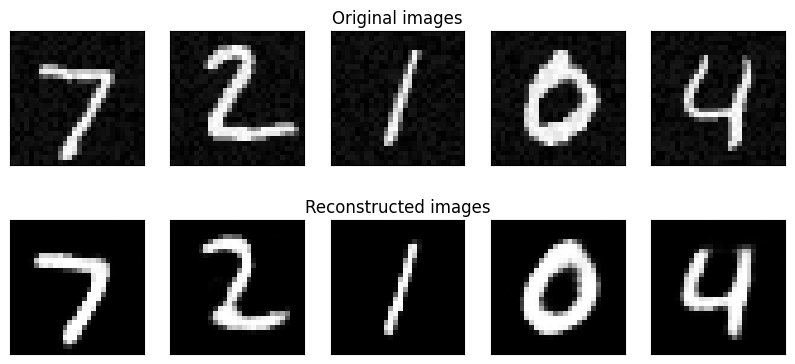

	 partial train loss (single batch): 0.299564
	 partial train loss (single batch): 0.299595
	 partial train loss (single batch): 0.303505
	 partial train loss (single batch): 0.302600
	 partial train loss (single batch): 0.301927
	 partial train loss (single batch): 0.302463
	 partial train loss (single batch): 0.299883
	 partial train loss (single batch): 0.307646
	 partial train loss (single batch): 0.300722
	 partial train loss (single batch): 0.305853
	 partial train loss (single batch): 0.301661
	 partial train loss (single batch): 0.301487
	 partial train loss (single batch): 0.308030
	 partial train loss (single batch): 0.303351
	 partial train loss (single batch): 0.302234
	 partial train loss (single batch): 0.304330
	 partial train loss (single batch): 0.305544
	 partial train loss (single batch): 0.306014
	 partial train loss (single batch): 0.302646
	 partial train loss (single batch): 0.299855
	 partial train loss (single batch): 0.304814
	 partial train loss (single batch

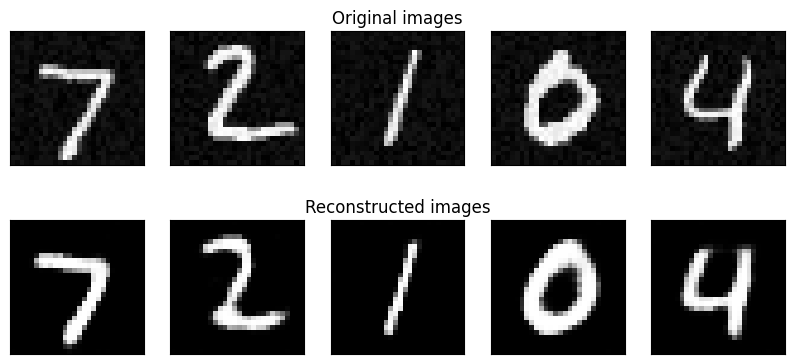

	 partial train loss (single batch): 0.299097
	 partial train loss (single batch): 0.298942
	 partial train loss (single batch): 0.302740
	 partial train loss (single batch): 0.301793
	 partial train loss (single batch): 0.300759
	 partial train loss (single batch): 0.301553
	 partial train loss (single batch): 0.298850
	 partial train loss (single batch): 0.306625
	 partial train loss (single batch): 0.299796
	 partial train loss (single batch): 0.305074
	 partial train loss (single batch): 0.300655
	 partial train loss (single batch): 0.300446
	 partial train loss (single batch): 0.306819
	 partial train loss (single batch): 0.302881
	 partial train loss (single batch): 0.301552
	 partial train loss (single batch): 0.303441
	 partial train loss (single batch): 0.304712
	 partial train loss (single batch): 0.305310
	 partial train loss (single batch): 0.301912
	 partial train loss (single batch): 0.298985
	 partial train loss (single batch): 0.304488
	 partial train loss (single batch

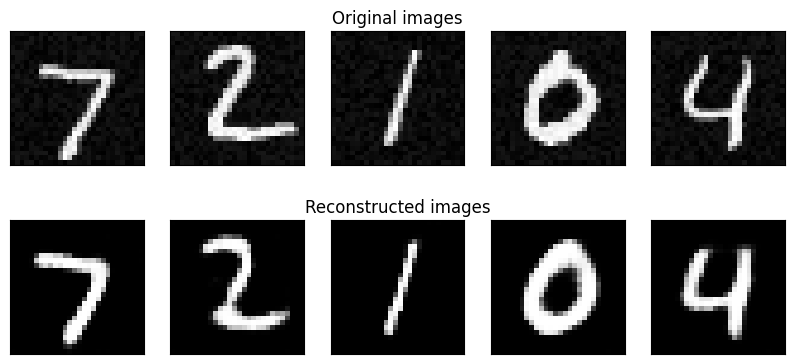

	 partial train loss (single batch): 0.298330
	 partial train loss (single batch): 0.298452
	 partial train loss (single batch): 0.301916
	 partial train loss (single batch): 0.301071
	 partial train loss (single batch): 0.300507
	 partial train loss (single batch): 0.301015
	 partial train loss (single batch): 0.298428
	 partial train loss (single batch): 0.305915
	 partial train loss (single batch): 0.298951
	 partial train loss (single batch): 0.304554
	 partial train loss (single batch): 0.300236
	 partial train loss (single batch): 0.300102
	 partial train loss (single batch): 0.306166
	 partial train loss (single batch): 0.301848
	 partial train loss (single batch): 0.300813
	 partial train loss (single batch): 0.302833
	 partial train loss (single batch): 0.303781
	 partial train loss (single batch): 0.304494
	 partial train loss (single batch): 0.301429
	 partial train loss (single batch): 0.298218
	 partial train loss (single batch): 0.303821
	 partial train loss (single batch

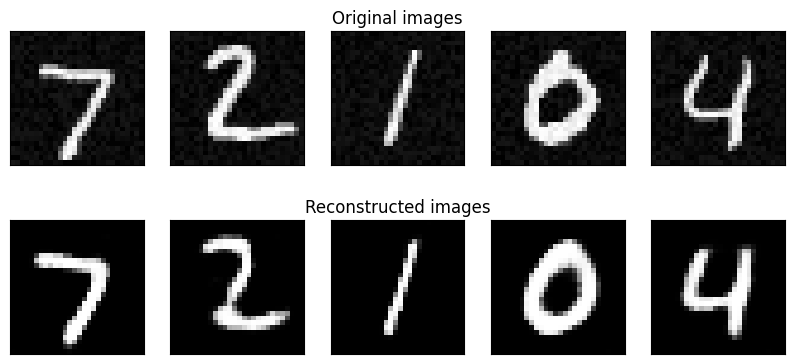

	 partial train loss (single batch): 0.297861
	 partial train loss (single batch): 0.297511
	 partial train loss (single batch): 0.301256
	 partial train loss (single batch): 0.300351
	 partial train loss (single batch): 0.299855
	 partial train loss (single batch): 0.299974
	 partial train loss (single batch): 0.297994
	 partial train loss (single batch): 0.305693
	 partial train loss (single batch): 0.298461
	 partial train loss (single batch): 0.303972
	 partial train loss (single batch): 0.299888
	 partial train loss (single batch): 0.299497
	 partial train loss (single batch): 0.305118
	 partial train loss (single batch): 0.301347
	 partial train loss (single batch): 0.300285
	 partial train loss (single batch): 0.302294
	 partial train loss (single batch): 0.303677
	 partial train loss (single batch): 0.303938
	 partial train loss (single batch): 0.300510
	 partial train loss (single batch): 0.297505
	 partial train loss (single batch): 0.303176
	 partial train loss (single batch

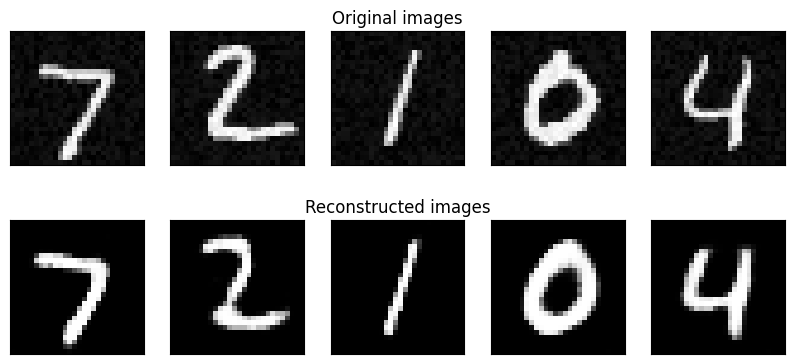

	 partial train loss (single batch): 0.297163
	 partial train loss (single batch): 0.297483
	 partial train loss (single batch): 0.300889
	 partial train loss (single batch): 0.299773
	 partial train loss (single batch): 0.299556
	 partial train loss (single batch): 0.299802
	 partial train loss (single batch): 0.297662
	 partial train loss (single batch): 0.304870
	 partial train loss (single batch): 0.298183
	 partial train loss (single batch): 0.303560
	 partial train loss (single batch): 0.298986
	 partial train loss (single batch): 0.299150
	 partial train loss (single batch): 0.304711
	 partial train loss (single batch): 0.300552
	 partial train loss (single batch): 0.299808
	 partial train loss (single batch): 0.301644
	 partial train loss (single batch): 0.303169
	 partial train loss (single batch): 0.303099
	 partial train loss (single batch): 0.299900
	 partial train loss (single batch): 0.297111
	 partial train loss (single batch): 0.302494
	 partial train loss (single batch

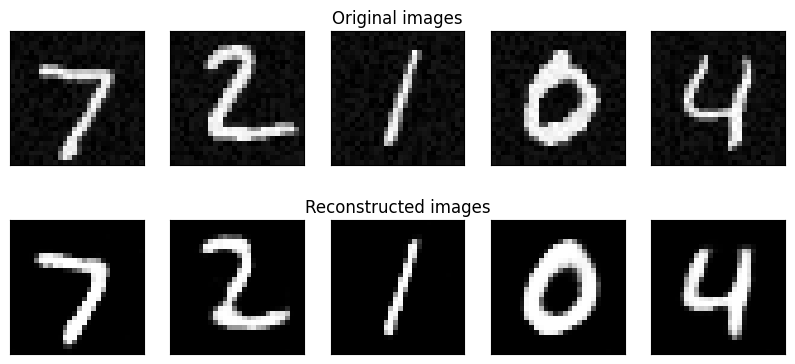

	 partial train loss (single batch): 0.296620
	 partial train loss (single batch): 0.296665
	 partial train loss (single batch): 0.300388
	 partial train loss (single batch): 0.299544
	 partial train loss (single batch): 0.298789
	 partial train loss (single batch): 0.299325
	 partial train loss (single batch): 0.296978
	 partial train loss (single batch): 0.304533
	 partial train loss (single batch): 0.297397
	 partial train loss (single batch): 0.302756
	 partial train loss (single batch): 0.298778
	 partial train loss (single batch): 0.298553
	 partial train loss (single batch): 0.304287
	 partial train loss (single batch): 0.300377
	 partial train loss (single batch): 0.299173
	 partial train loss (single batch): 0.301088
	 partial train loss (single batch): 0.302831
	 partial train loss (single batch): 0.302882
	 partial train loss (single batch): 0.299103
	 partial train loss (single batch): 0.296781
	 partial train loss (single batch): 0.302053
	 partial train loss (single batch

KeyboardInterrupt: 

In [21]:
num_epochs = 20
history = {'train_loss': [], 'val_loss': []}

for epoch in range(num_epochs):
    train_loss = train_epoch(encoder, decoder, device, train_loader, loss_fn, optim)
    val_loss = test_epoch(encoder, decoder, device, valid_loader, loss_fn)

    print('\n EPOCH %d/%d \t train loss %.3f \t val loss %.3f' % (epoch + 1, num_epochs, train_loss, val_loss))

    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)

    plot_ae_outputs(encoder, decoder, n=5)

In [22]:
test_epoch(encoder, decoder, device, test_loader, loss_fn).item()

0.3009698987007141

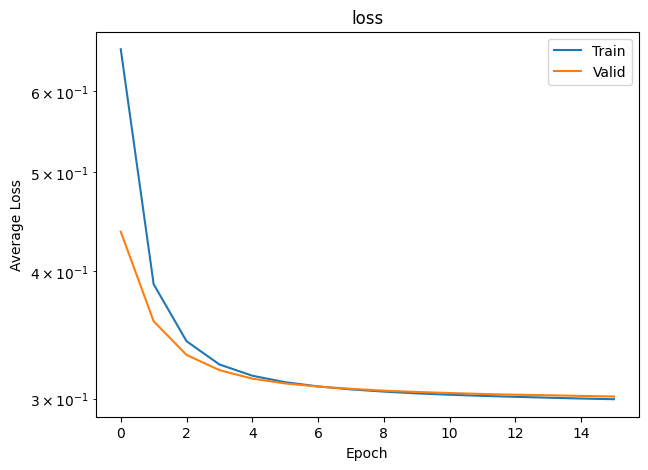

In [23]:
plt.figure(figsize=(7,5))
plt.semilogy(history['train_loss'], label='Train')
plt.semilogy(history['val_loss'], label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.legend()
plt.title('loss')
plt.show()